## Test object detection using remote camera server, cleint

#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/3D_Object_Detection/src/scripts/demo_2022/demo_utils/shared_detector.py
```


#### Run remote camera streaming server (robot-side pc)
```bash
python3 cam_grpc_sever.py
```

In [1]:
import os
import sys
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

os.chdir(os.path.join(os.environ["HOME"], "Projects/3D_Object_Detection/src"))
sys.path.append(os.path.join(os.environ["HOME"], "Projects/3D_Object_Detection/src"))
sys.path.append(os.path.join(os.environ["HOME"], "Projects/3D_Object_Detection/src/scripts/demo_202210"))

import grpc
from pkg.detector.grpc_cam.RemoteCam_pb2 import *
from pkg.detector.grpc_cam.RemoteCam_pb2_grpc import *
from pkg.detector.ICP_Detector import *

CONNECT_CAM = True
CONNECT_ROBOT = False
ENABLE_DETECT = True

In [2]:
from pkg.utils.rotation_utils import *
from indy_utils_dh.indydcp_client import IndyDCPClient
from scipy.spatial.transform import Rotation

server_ip = "192.168.1.6"  # check always the robot ip
robot_name = "NRMK-Indy7"

# generate indydcp client
indy = IndyDCPClient(server_ip, robot_name)


# from geometry_msgs.msg import Point
# from controller.kiro_tool import *
# from controller.move_robot import move_joint_traj, move_raw_joint_traj
# from utils.traj_utils import simplify_traj
# from utils.kinematic_utils import *
# from controller.indy_utils import *
# from compliant_controller_client import *

In [3]:
#######################################################
############### read robot joint state ################
#######################################################

# # Move indy to view sofa
# VIEW_POS_SOFA = [25, 30, -55, 0, -105, 0]
# VIEW_POS_SOFA = [65, 17, -55, 0, -105, -90] # new
# VIEW_POS_SOFA = [112, 11, -55, 0, -105, -90] # old

# closet view pose
VIEW_POS_CLOSET = [15, 30, -35, 0, -95, 0]

pos_tool_deg = 30
move_tool_packet = create_move_tool_packet(round(10*pos_tool_deg), vel=14)
kiro_tool_port.send(move_tool_packet)
if robot_available:
    indy.connect()
    indy.joint_move_to(VIEW_POS_CLOSET)
    indy.wait_for_move_finish()
    indy.disconnect()

# # Read current robot state (joint value)
    indy.connect()
    pos_cur_deg = indy.get_joint_pos()
    print("\nCurrent robot pos[deg]:")
    print(pos_cur_deg)

    pos_cur = np.deg2rad(pos_cur_deg)
    indy.disconnect()
else:
    pos_cur = np.deg2rad(VIEW_POS_SOFA)

pos_base = [0]*6
pos_tool =  np.deg2rad(pos_tool_deg)
robot_joint_config = list(pos_base) + list(pos_cur) + [pos_tool]

gscene.set_robot_joint_state(robot_joint_config)

T_w6 = gscene.combined_robot.calc_link_transform("map", "indy0_link6", robot_joint_config)
T_6v = np.array([[1, 0, 0, 0], [0, 1, 0, -0.066], [0, 0, 1, 0.073], [0, 0, 0, 1]]) # link6 to camera
T_wc = np.matmul(T_w6, T_6v)

NameError: name 'create_move_tool_packet' is not defined

## Detector Client 

In [4]:
# generate Detector Client
detector = Detector_Client()

======= Initialize Done =======


In [5]:
# get camera configuraiton
config = detector.get_camera_config()
print("Camera Matrix: ")
print(config[0])
print("\nDist Coeffs: ")
print(config[1])
print("\nDepth Scale: ")
print(config[2])

Camera Matrix: 
[[ 899.05322266    0.          654.88366699]
 [   0.          899.21044922  352.92956543]
 [   0.            0.            1.        ]]

Dist Coeffs: 
[ 0.15870179 -0.46903715 -0.0014261   0.00066797  0.41631824]

Depth Scale: 
0.000250000011874


In [6]:
# get color, depth image
color, depth = detector.get_image()

 ======= Success to receive color, depth image =======


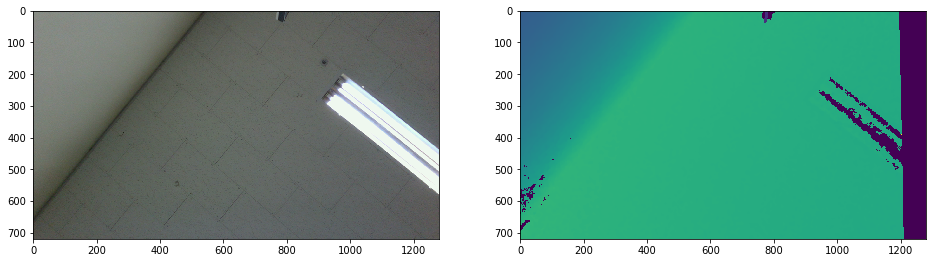

In [7]:
# show color, depth image
fig = plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.imshow(color[:,:,[2,1,0]])
plt.subplot(1,2,2)
plt.imshow(depth)

### Object Detection through Swin-Transformer Cascade Mask RCNN

#### Mask RCNN

In [8]:
# shared detector
from pkg.detector.shared_detector import SharedDetectorGenerator
# from scripts.demo_202208.cam_stream_grpc.demo_utils.shared_detector import SharedDetectorGenerator
sd = SharedDetectorGenerator(tuple(reversed(detector.img_dim))+(3,))()

if ENABLE_DETECT:
    sd.init()
    detector.set_shared_detector(sd)

In [11]:
# inference through CasCade MaskRCNN
mask_out_list = detector.inference(sd, color)
sofa_idx = 57
refrigerator_idx = 72

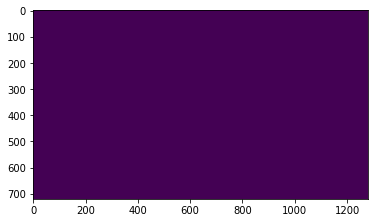

In [10]:
plt.imshow(mask_out_list[57])

#### ICP

In [11]:
# Read current robot state (joint value)

if CONNECT_ROBOT:
    indy.connect()
    pos_cur_deg = indy.get_joint_pos()
    print("Current robot pos[deg]:")
    print(pos_cur_deg)
    pos_cur = np.deg2rad(pos_cur_deg)
    indy.disconnect()
else:
    print("Robot is not connected!")

Connect: Server IP (192.168.1.6)

Current robot pos[deg]:
[-4.488868398114965, 89.09571623999813, 26.661049078320456, 6.203141920637785, -29.24272291731319, 85.6058494643466]


In [22]:
##
# @brief   camera coordinate offset w.r.t tcp
def get_camera_offset():
    T = np.identity(4)
    T[:3,:3] = Rot_axis(3, -np.pi/2)
    T[:3,3] = np.array([-0.066,0,0.073])
#     T_6v = np.array([[0, 1, 0, -0.066],
#                  [-1,  0, 0, 0],
#                  [0,  0, 1, 0.073],
#                  [0,  0, 0, 1]]) # link6 to camera
    return T

In [15]:
# get camera location (Tc)

if CONNECT_ROBOT:
    indy.connect()
    tPos = indy.get_task_pos()
    indy.disconnect()

T = T_xyzrpy(tPos)
Toff = get_camera_offset()
Tc = np.matmul(Tc, Toff)
T_cb = np.linalg.inv(Tc)

NameError: name 'tPos' is not defined

In [26]:
# load object info
from pkg.detector.config import *

obj_info_dict = get_obj_info()

micp_bed = MultiICP_Obj(obj_info_dict["bed"])
micp_closet = MultiICP_Obj(obj_info_dict["closet"])
micp_sofa = MultiICP_Obj(obj_info_dict["couch"])
micp_refri = MultiICP_Obj(obj_info_dict["refrigerator"])


micp_dict = {"bed": micp_bed, "closet": micp_closet, "couch": micp_sofa, "refrigerator":micp_refri}

In [14]:
# initial guess for ICP

Tbo_bed = np.identity(4)
Tbo_closet = np.identity(4)
Tbo_sofa = np.identity(4)
Tbo_refri = np.identity(4)

initial_list = {"bed":Tbo_bed, "closet":Tbo_closet, "couch":Tbo_sofa, "refrigerator":Tbo_refri,}

In [15]:
cam_client.set_config(micp_dict, sd, initial_list)

In [16]:
cam_client.set_merge_mask(merge=True)
cam_client.set_inlier_ratio(ratio=0.02)
cam_client.detect(sd, Tc, "couch", visualize=True)

[Info] name_mask is couch
 ======= Success to receive color, depth image =======
===== Detected : couch, 1 object(s) =====
[NOTICE] You choose merge option for mask. Detected masks would be merged.

 Use intial guess of 'couch'

initial: 
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


cam_stream_grpc/demo_utils/rotation_utils.py:304: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(z/radius)
cam_stream_grpc/cam_grpc_client.py:763: RuntimeWarning: divide by zero encountered in divide
  points_converted = points_converted[np.where(np.abs(points_converted[:,0]/points_converted[:,2]) < np.tan(h_fov_hf))]


Apply point-to-point ICP
registration::RegistrationResult with fitness=3.247261e-01, inlier_rmse=4.836201e-02, and correspondence_set size of 830
Access transformation to get result.
Transformation is:
[[ 0.98179387 -0.18034432  0.0596383  -0.12120694]
 [ 0.1728816   0.71831553 -0.67389521  1.08313834]
 [ 0.07869406  0.67193655  0.736416    0.45893669]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.98179387 -0.18034432  0.0596383  -0.12120694]
 [ 0.1728816   0.71831553 -0.67389521  1.08313834]
 [ 0.07869406  0.67193655  0.736416    0.45893669]
 [ 0.          0.          0.          1.        ]]
result: 
[[ 0.98 -0.18  0.06 -0.12]
 [ 0.17  0.72 -0.67  1.08]
 [ 0.08  0.67  0.74  0.46]
 [ 0.    0.    0.    1.  ]]
Inlier ratio: 0.0129750715161


{}